# Out of Distribution (External) Evaluation

This is for resampling evaluation approach

In [3]:

from typing import *

import joblib
import mimic_pipeline.utils as utils
import numpy as np
import pandas as pd
from mimic_pipeline.metric import get_calibration_curve, get_model_size
from sklearn.metrics import (auc, brier_score_loss, precision_recall_curve,
                             roc_curve)

user = input("Enter your username: ")
password = input("Enter your password: ")
loader = utils.DataBaseLoader(user=user, password=password, dbname='eicu', schema='eicu')
SOFA = loader["sofa"]

def ood_evaluate(eicu_df, model: str, exp: str, save: bool=False) -> Optional[dict]:
    # print(f"Evaluating OOD performance for {model}...")
    if model in ['sapsii_prob', 'oasis_prob', 'apache_iv_prob', 'apache_iva_prob', "sofa_emp_prob"]:
        pass
    else:
        trained_model = joblib.load(f"models/{model}/model.joblib")
    X_test, y_test = eicu_df.drop(['uniquepid', 'patientunitstayid', 'hospital_expire_flag', 'apache_iv_prob', 'apache_iva_prob', 'oasis_prob', 'sapsii_prob'], axis=1), eicu_df['hospital_expire_flag']
    if exp == 'oasis+' or model == 'fasterrisk-oasis':
        oasis_features = [
            'heartrate_min', 'heartrate_max', 'meanbp_min', 'meanbp_max', 'resprate_min', 'resprate_max', 'tempc_min', 
            'tempc_max', 'urineoutput', 'mechvent', 'electivesurgery', 'age', 'gcs_min', 'preiculos'
        ]
        X_test = X_test[oasis_features]
    
    if 'fasterrisk' in model or model in ['nonlinear-logreg-l1', 'nonlinear-logreg-l2']:
        binarizer = joblib.load(f"models/{model}/binarizer.joblib")
        X_test, _ = binarizer.transform(X_test)
        y_prob = trained_model.predict_proba(X_test.to_numpy())
    elif model in ['sapsii_prob', 'oasis_prob', 'apache_iv_prob', 'apache_iva_prob', 'sofa_emp_prob']:
        if model == 'sofa_emp_prob':
            eicu_df = eicu_df.merge(SOFA[['uniquepid', 'patientunitstayid', 'sofa_emp_prob']], on=['uniquepid', 'patientunitstayid'], how='left')
        y_prob = eicu_df[model]
    else:
        imputer = joblib.load(f"models/{exp}/{model}/imputer.joblib")
        scaler = joblib.load(f"models/{exp}/{model}/scaler.joblib")
        columns = list(X_test.columns)
        X_test = imputer.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=columns)
        X_test = scaler.transform(X_test)
        y_prob = trained_model.predict_proba(X_test)
    
    if len(y_prob.shape) == 2:        # for some scikit-learn models where probas is 2D
        y_prob = y_prob[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auroc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auprc = auc(recall, precision)
    prob_true, prob_pred, h_stat, p1 = get_calibration_curve(y_test, y_prob)
    _, _, c_stat, p2 = get_calibration_curve(y_test, y_prob, strategy='quantile')
    brier = brier_score_loss(y_test, y_prob)
    smr = np.sum(y_test.replace({-1: 0})) / np.sum(y_prob)
    if model not in ['sapsii_prob', 'oasis_prob', 'apache_iv_prob', 'apache_iva_prob', 'sofa_emp_prob']:
        complexity = get_model_size(trained_model)
    else:
        complexity = 'NA'
    
    # print(f"AUROC: {auroc}\nAUPRC: {auprc}\nHosmer Lemeshow H stat: {h_stat}, P-Value: {p1}\nHosmer Lemeshow C stat: {c_stat}, P-Value: {p2}\nBrier Score: {brier}\nSMR: {smr}\nComplexity: {complexity}\n")
    
    stats = {
        "auroc": auroc, "auprc": auprc, "precision": precision, "recall": recall, "fpr": fpr, "tpr": tpr, 
        "true_prob": prob_true, "pred_prob": prob_pred, "h-stat": h_stat, "h-p-value": p1, "c-stat": c_stat, 
        "c-p-value": p2, "brier": brier, "smr": smr, 'complexity': complexity,
    }
    
    if save:
        if model not in ['sapsii_prob', 'oasis_prob', 'apache_iv_prob', 'apache_iva_prob', 'sofa_emp_prob']:
            joblib.dump(stats, f"results/{exp}/{model}-ood-stats")
        else:
            joblib.dump(stats, f"results/{model}-ood-stats")
    else:
        return stats
    

## FasterRisk

In [4]:
eicu_df = pd.read_csv('data/eICU-union.csv')

In [3]:
from scipy.stats import ttest_rel
import joblib

result_dict = {}

def see_statistical_significance(fasterrisk_result, alternative_result, alternative: str='two-sided', sig_level: float=0.05):
    t_stat, p_val = ttest_rel(fasterrisk_result, alternative_result, alternative=alternative)

    if p_val < sig_level:
        sig = "*** SIGNIFICANT ***"
    else:
        sig = "*** NOT SIGNIFICANT ***"
    print(f"Performance: {sig}\nstatistic={t_stat}, p={p_val}\n")

In [4]:
import random
import mimic_pipeline.utils as utils

utils.seed_everything()
SAMPLE_SIZE = 50_000

for model in ["oasis_prob", "sapsii_prob", "apache_iv_prob", "apache_iva_prob"]:
    auroc, auprc = [], []
    for _ in range(5):
        indices = np.arange(len(eicu_df))
        random.shuffle(indices)
        tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
        stats = ood_evaluate(tmp_df, model=model, exp='oasis+', save=False)
        auroc.append(stats["auroc"])
        auprc.append(stats["auprc"])
    print(f"{model}, AUROC: {np.mean(auroc):.3f}$\pm${np.std(auroc):.3f}, AUPRC: {np.mean(auprc):.3f}$\pm${np.std(auprc):.3f}")
    result_dict[model] = {"auroc": auroc, "auprc": auprc}

oasis_prob, AUROC: 0.805$\pm$0.003, AUPRC: 0.360$\pm$0.006
sapsii_prob, AUROC: 0.844$\pm$0.002, AUPRC: 0.436$\pm$0.002
apache_iv_prob, AUROC: 0.872$\pm$0.001, AUPRC: 0.492$\pm$0.004
apache_iva_prob, AUROC: 0.872$\pm$0.002, AUPRC: 0.486$\pm$0.005


In [5]:
import random
import mimic_pipeline.utils as utils

utils.seed_everything()

for group_sparsity in [10, 15, 40]:
    auroc, auprc = [], []
    for _ in range(5):
        indices = np.arange(len(eicu_df))
        random.shuffle(indices)
        tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
        stats = ood_evaluate(tmp_df, model=f'fasterrisk-{group_sparsity}_o', exp='fasterrisk', save=False)
        auroc.append(stats["auroc"])
        auprc.append(stats["auprc"])
    print(f"Group Sparsity: {group_sparsity}, AUROC: {np.mean(auroc):.3f}$\pm${np.std(auroc):.3f}, AUPRC: {np.mean(auprc):.3f}$\pm${np.std(auprc):.3f}")
    result_dict[f'fasterrisk-{group_sparsity}'] = {"auroc": auroc, "auprc": auprc}

Group Sparsity: 10, AUROC: 0.839$\pm$0.002, AUPRC: 0.429$\pm$0.009
Group Sparsity: 15, AUROC: 0.856$\pm$0.002, AUPRC: 0.466$\pm$0.003
Group Sparsity: 40, AUROC: 0.863$\pm$0.001, AUPRC: 0.494$\pm$0.004


In [6]:
print("OASIS")
for metric in ["auroc", "auprc"]:
    print(f"Metric: {metric}")
    see_statistical_significance(result_dict["fasterrisk-10"][metric], result_dict["oasis_prob"][metric], alternative="greater")

print("SAPSII")
for metric in ["auroc", "auprc"]:
    print(f"Metric: {metric}")
    see_statistical_significance(result_dict["fasterrisk-15"][metric], result_dict["sapsii_prob"][metric], alternative="greater")

print("APACHE IV")
for metric in ["auroc", "auprc"]:
    print(f"Metric: {metric}")
    see_statistical_significance(result_dict["fasterrisk-40"][metric], result_dict["apache_iv_prob"][metric], alternative="greater")

print("APACHE IVa")
for metric in ["auroc", "auprc"]:
    print(f"Metric: {metric}")
    see_statistical_significance(result_dict["fasterrisk-40"][metric], result_dict["apache_iva_prob"][metric], alternative="greater")

OASIS
Metric: auroc
Performance: *** SIGNIFICANT ***
statistic=32.26122307653189, p=2.7518275661402326e-06

Metric: auprc
Performance: *** SIGNIFICANT ***
statistic=29.11418485065835, p=4.14280681793581e-06

SAPSII
Metric: auroc
Performance: *** SIGNIFICANT ***
statistic=11.689502646147377, p=0.0001531229252438735

Metric: auprc
Performance: *** SIGNIFICANT ***
statistic=26.22892623706216, p=6.2777258050497e-06

APACHE IV
Metric: auroc
Performance: *** NOT SIGNIFICANT ***
statistic=-17.970531905351475, p=0.9999718184497935

Metric: auprc
Performance: *** NOT SIGNIFICANT ***
statistic=1.1513383642979742, p=0.15686531119896696

APACHE IVa
Metric: auroc
Performance: *** NOT SIGNIFICANT ***
statistic=-13.091706444222936, p=0.9999017280579701

Metric: auprc
Performance: *** SIGNIFICANT ***
statistic=3.282276095731995, p=0.01521777105048246



## Disease Specific

In [11]:
import random
import mimic_pipeline.utils as utils
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

utils.seed_everything()
SAMPLE_SIZE = 3000

def see_statistical_significance(fasterrisk_result, alternative_result, alternative: str='two-sided', sig_level: float=0.05):
    t_stat, p_val = ttest_rel(fasterrisk_result, alternative_result, alternative=alternative)

    if p_val < sig_level:
        sig = "*** SIGNIFICANT ***"
    else:
        sig = "*** NOT SIGNIFICANT ***"
    print(f"Performance: {sig}\nstatistic={t_stat}, p={p_val}\n")

for disease in ["akf", "ami", "heart_failure", "sepsis"]:
    print(f"*** {disease} ***")
    eicu_df = pd.read_csv(f"data/eicu-disease/{disease}-union-features-id.csv")

    result_dict = {}

    for model in ["oasis_prob", "sapsii_prob", "apache_iv_prob", "apache_iva_prob", "sofa_emp_prob"]:
        auroc, auprc = [], []
        for _ in range(5):
            indices = np.arange(len(eicu_df))
            random.shuffle(indices)
            tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
            stats = ood_evaluate(tmp_df, model=model, exp='oasis+', save=False)
            auroc.append(stats["auroc"])
            auprc.append(stats["auprc"])
        print(f"{model}, AUROC: {np.mean(auroc):.3f}$\pm${np.std(auroc):.3f}, AUPRC: {np.mean(auprc):.3f}$\pm${np.std(auprc):.3f}")
        result_dict[model] = {"auroc": auroc, "auprc": auprc}

    utils.seed_everything()

    for group_sparsity in [10, 15, 40]:
        auroc, auprc = [], []
        for _ in range(5):
            indices = np.arange(len(eicu_df))
            random.shuffle(indices)
            tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
            stats = ood_evaluate(tmp_df, model=f'fasterrisk-{group_sparsity}_o', exp='fasterrisk', save=False)
            auroc.append(stats["auroc"])
            auprc.append(stats["auprc"])
        print(f"Group Sparsity: {group_sparsity}, AUROC: {np.mean(auroc):.3f}$\pm${np.std(auroc):.3f}, AUPRC: {np.mean(auprc):.3f}$\pm${np.std(auprc):.3f}")
        result_dict[f'fasterrisk-{group_sparsity}'] = {"auroc": auroc, "auprc": auprc}

    print("OASIS")
    for metric in ["auroc", "auprc"]:
        print(f"Metric: {metric}")
        see_statistical_significance(result_dict["fasterrisk-10"][metric], result_dict["oasis_prob"][metric], alternative="greater")

    print("SAPSII")
    for metric in ["auroc", "auprc"]:
        print(f"Metric: {metric}")
        see_statistical_significance(result_dict["fasterrisk-15"][metric], result_dict["sapsii_prob"][metric], alternative="greater")

    print("APACHE IV")
    for metric in ["auroc", "auprc"]:
        print(f"Metric: {metric}")
        see_statistical_significance(result_dict["fasterrisk-40"][metric], result_dict["apache_iv_prob"][metric], alternative="greater")

    print("APACHE IVa")
    for metric in ["auroc", "auprc"]:
        print(f"Metric: {metric}")
        see_statistical_significance(result_dict["fasterrisk-40"][metric], result_dict["apache_iva_prob"][metric], alternative="greater")

*** akf ***
oasis_prob, AUROC: 0.756$\pm$0.011, AUPRC: 0.425$\pm$0.018
sapsii_prob, AUROC: 0.780$\pm$0.005, AUPRC: 0.484$\pm$0.013
apache_iv_prob, AUROC: 0.798$\pm$0.006, AUPRC: 0.502$\pm$0.013
apache_iva_prob, AUROC: 0.797$\pm$0.006, AUPRC: 0.507$\pm$0.013
sofa_emp_prob, AUROC: 0.722$\pm$0.009, AUPRC: 0.416$\pm$0.016
Group Sparsity: 10, AUROC: 0.770$\pm$0.010, AUPRC: 0.473$\pm$0.019
Group Sparsity: 15, AUROC: 0.795$\pm$0.008, AUPRC: 0.514$\pm$0.016
Group Sparsity: 40, AUROC: 0.819$\pm$0.008, AUPRC: 0.551$\pm$0.018
OASIS
Metric: auroc
Performance: *** SIGNIFICANT ***
statistic=2.1911938640385302, p=0.04678365268578534

Metric: auprc
Performance: *** SIGNIFICANT ***
statistic=5.159452415789183, p=0.0033502775380336814

SAPSII
Metric: auroc
Performance: *** SIGNIFICANT ***
statistic=5.388223177079906, p=0.002868529658450313

Metric: auprc
Performance: *** SIGNIFICANT ***
statistic=9.593502515706207, p=0.00032990661478943706

APACHE IV
Metric: auroc
Performance: *** SIGNIFICANT ***
statis

## Union 49 For Other ML Models

In [5]:
for model in ['ebm', 'nonlinear-logreg-l1', 'nonlinear-logreg-l2', 'random-forest', 'adaboost', 'xgboost']:
    ood_evaluate(eicu_df, model=model, exp='union49', save=True)

Evaluating OOD performance for ebm...
AUROC: 0.8732586246087883
AUPRC: 0.4726423493251309
Hosmer Lemeshow H stat: 56.47658861416762, P-Value: 2.2778517960730937e-09
Hosmer Lemeshow C stat: 77.18500796399475, P-Value: 1.7985612998927536e-13
Brier Score: 0.052561097414966985
SMR: 0.9559597477122928
Complexity: 11329

Evaluating OOD performance for nonlinear-logreg-l1...


/usr/local/anaconda3/envs/474/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


AUROC: 0.8703446392083694
AUPRC: 0.4649494459148591
Hosmer Lemeshow H stat: 113.08738915185499, P-Value: 0.0
Hosmer Lemeshow C stat: 135.32079095315163, P-Value: 0.0
Brier Score: 0.052913503651601815
SMR: 0.9157501071258832
Complexity: 422

Evaluating OOD performance for nonlinear-logreg-l2...


/usr/local/anaconda3/envs/474/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


AUROC: 0.8669659590625871
AUPRC: 0.46941436890575805
Hosmer Lemeshow H stat: 413.0960531092308, P-Value: 0.0
Hosmer Lemeshow C stat: 384.17494943437293, P-Value: 0.0
Brier Score: 0.05327122487610381
SMR: 0.837673476992704
Complexity: 3793

Evaluating OOD performance for random-forest...
AUROC: 0.874758168133601
AUPRC: 0.47209137175750526
Hosmer Lemeshow H stat: 1790.6522242969456, P-Value: 0.0
Hosmer Lemeshow C stat: 1546.2526439692087, P-Value: 0.0
Brier Score: 0.05469424634643788
SMR: 0.8100111338678684
Complexity: 653237

Evaluating OOD performance for adaboost...
AUROC: 0.8578352863209968
AUPRC: 0.44812091681979127
Hosmer Lemeshow H stat: 66221.95547753117, P-Value: 0.0
Hosmer Lemeshow C stat: 68129.90397919725, P-Value: 0.0
Brier Score: 0.21568885779182742
SMR: 0.16463021837871036
Complexity: 997

Evaluating OOD performance for xgboost...
AUROC: 0.87830238444439
AUPRC: 0.4792198726265071
Hosmer Lemeshow H stat: 32745.634343545204, P-Value: 0.0
Hosmer Lemeshow C stat: 77927.1101436

## OASIS+ Models

In [6]:
for model in ['ebm', 'nonlinear-logreg-l1', 'nonlinear-logreg-l2', 'random-forest', 'adaboost', 'xgboost']:
    ood_evaluate(eicu_df, model=model, exp='oasis+', save=True)

Evaluating OOD performance for ebm...
AUROC: 0.844663878404776
AUPRC: 0.4216152770618654
Hosmer Lemeshow H stat: 128.31880580651065, P-Value: 0.0
Hosmer Lemeshow C stat: 175.41002722184035, P-Value: 0.0
Brier Score: 0.05548000594107118
SMR: 1.04137932722551
Complexity: 1870

Evaluating OOD performance for nonlinear-logreg-l1...


/usr/local/anaconda3/envs/474/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


AUROC: 0.8494633181619304
AUPRC: 0.43499599132897304
Hosmer Lemeshow H stat: 275.80362271082134, P-Value: 0.0
Hosmer Lemeshow C stat: 285.4121151507853, P-Value: 0.0
Brier Score: 0.05466142983657784
SMR: 0.9099116836955317
Complexity: 169

Evaluating OOD performance for nonlinear-logreg-l2...


/usr/local/anaconda3/envs/474/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


AUROC: 0.8454294536590766
AUPRC: 0.43732712444071886
Hosmer Lemeshow H stat: 534.8996797570794, P-Value: 0.0
Hosmer Lemeshow C stat: 528.1644116830238, P-Value: 0.0
Brier Score: 0.05476741918716991
SMR: 0.8294618277443934
Complexity: 997

Evaluating OOD performance for random-forest...
AUROC: 0.8391179276927851
AUPRC: 0.40541546068738926
Hosmer Lemeshow H stat: 529.3111715182113, P-Value: 0.0
Hosmer Lemeshow C stat: 431.1143345343917, P-Value: 0.0
Brier Score: 0.05699877409644747
SMR: 0.9600415777745375
Complexity: 592967

Evaluating OOD performance for adaboost...
AUROC: 0.8099034172278652
AUPRC: 0.35866179453819463
Hosmer Lemeshow H stat: 45825.246774068386, P-Value: 0.0
Hosmer Lemeshow C stat: 46530.70669003511, P-Value: 0.0
Brier Score: 0.16358208517066197
SMR: 0.19484973486642726
Complexity: 1195

Evaluating OOD performance for xgboost...
AUROC: 0.8311345435208991
AUPRC: 0.3868702891944197
Hosmer Lemeshow H stat: 188.72085030806878, P-Value: 0.0
Hosmer Lemeshow C stat: 195.8514062

## Group Sparsity

[0.8386502130334579, 0.8562489584375255, 0.8622571501546339, 0.8565163470871326, 0.8563706347303508, 0.8629905377958215, 0.863040931664153, 0.8603848440908015] [0.0022412355631843362, 0.0021728034599798485, 0.0007034805837855148, 0.0005529708601221254, 0.001333237789703716, 0.0021503639497829348, 0.001237064726959261, 0.0013468404607548925]


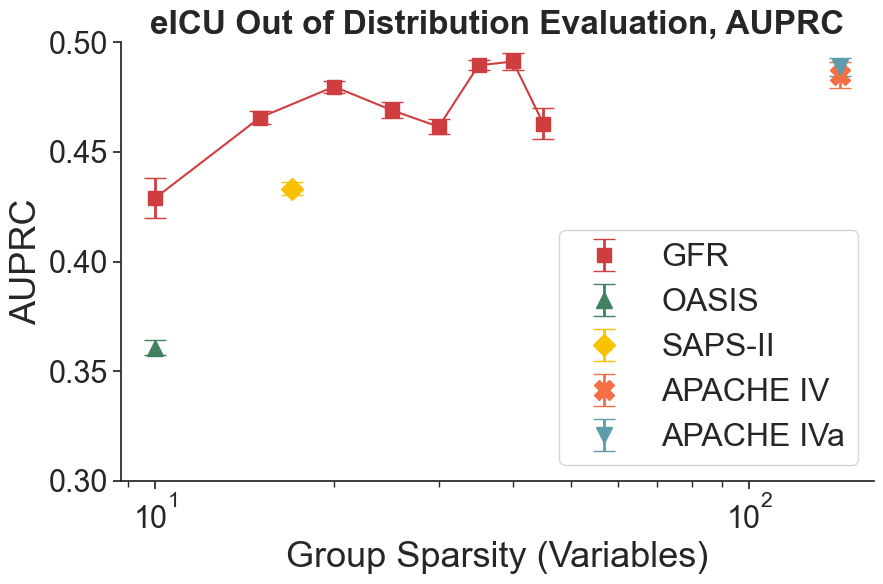

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import mimic_pipeline.utils as utils
import numpy as np
import random

utils.seed_everything()
SAMPLE_SIZE = 50_000

def plot_group_sparsity_performance_ood(ax, metric: str, linewidth=1, error_width=80, markersize=4, capsize=6, fmt='s', figsize=(8,6), fontsize=14) -> None:
    color = iter(sns.color_palette())
    assert metric in ['auroc', 'auprc']
    auroc_mean, auroc_std, auprc_mean, auprc_std = [], [], [], []
    base_dict = {}
    utils.seed_everything()

    for group_sparsity in range(10, 50, 5):
        auroc, auprc = [], []
        for _ in range(5):
            indices = np.arange(len(eicu_df))
            random.shuffle(indices)
            tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
            stats = ood_evaluate(tmp_df, model=f'fasterrisk-{group_sparsity}_o', exp='fasterrisk', save=False)
            auroc.append(stats["auroc"])
            auprc.append(stats["auprc"])
        
        auroc_mean.append(np.mean(auroc))
        auroc_std.append(np.std(auroc))
        auprc_mean.append(np.mean(auprc))
        auprc_std.append(np.std(auprc))
    
    for model in ["oasis_prob", "sapsii_prob", "apache_iv_prob", "apache_iva_prob", "sofa_emp_prob"]:
        auroc, auprc = [], []
        for _ in range(5):
            indices = np.arange(len(eicu_df))
            random.shuffle(indices)
            tmp_df = eicu_df.iloc[indices[:SAMPLE_SIZE]]
            stats = ood_evaluate(tmp_df, model=model, exp='oasis+', save=False)
            auroc.append(stats["auroc"])
            auprc.append(stats["auprc"])
        
        base_dict[f"{model}_auroc_mean"] = np.mean(auroc)
        base_dict[f"{model}_auroc_std"] = np.std(auroc)
        base_dict[f"{model}_auprc_mean"] = np.mean(auprc)
        base_dict[f"{model}_auprc_std"] = np.std(auprc)

    print(auroc_mean, auroc_std)
    ax.plot(list(range(10, 50, 5)), auprc_mean, color='#cf3d3e', linewidth=linewidth)
    ax.errorbar(list(range(10, 50, 5)), auprc_mean, yerr=auprc_std, fmt='s', capsize=capsize, color='#cf3d3e', linewidth=error_width, markersize=markersize, label='GFR')
    
    # ax.plot(list(range(10, 50, 5)), y2, color='grey', linewidth=linewidth)
    # ax.errorbar(x=list(range(10, 50, 5)), y=y2, fmt='o', capsize=capsize, color='grey', linewidth=error_width, markersize=markersize, label='AutoScore')
    
    ax.errorbar(10, base_dict["oasis_prob_auprc_mean"], base_dict["oasis_prob_auprc_std"], color='#40815f', capsize=capsize, fmt='^', markersize=12, linewidth=error_width, label='OASIS')
    ax.errorbar(17, base_dict["sapsii_prob_auprc_mean"], base_dict["sapsii_prob_auprc_std"], color='#FAC100', capsize=capsize, fmt='D', markersize=11, linewidth=error_width, label='SAPS-II')
    ax.errorbar(142, base_dict["apache_iv_prob_auprc_mean"], base_dict["apache_iv_prob_auprc_std"], color='#f46F43', capsize=capsize, fmt='X', markersize=14, linewidth=error_width, label='APACHE IV')
    ax.errorbar(142, base_dict["apache_iva_prob_auprc_mean"], base_dict["apache_iva_prob_auprc_std"], color='#5d9cab', capsize=capsize, fmt='v', markersize=12, linewidth=error_width, label='APACHE IVa')
    ax.set_xscale('log')
    ax.set_xlabel('Group Sparsity (Variables)', fontsize=fontsize+4)
    ax.set_title(f"eICU Out of Distribution Evaluation, {metric.upper()}", fontsize=fontsize+2, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.set_style('ticks')
fontsize = 22
linewidth = 1.5
error_width = 2
capsize = 8
markersize = 10
figsize = (9, 6)

ylim1 = (0.7, 0.9)
ylim2 = (0.3, 0.5)

# fig, axes = plt.subplots(figsize=figsize)
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9) 
# plot_group_sparsity_performance(axes, 'auroc', fontsize=fontsize, linewidth=linewidth, error_width=error_width, capsize=capsize, markersize=markersize)
# plt.ylim(ylim1)
# plt.ylabel("AUROC", fontsize=fontsize+4)
# sns.despine()
# plt.tight_layout()
# plt.savefig('group_sparsity_autoscore_perform_1.pdf', dpi=300, format='pdf')
# # plt.tight_layout()
# plt.close()

# fig, axes = plt.subplots(figsize=figsize)
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
# plot_group_sparsity_performance(axes, 'auprc', fontsize=fontsize, linewidth=linewidth, error_width=error_width, capsize=capsize, markersize=markersize)
# plt.ylim(ylim2)
# plt.ylabel("AUPRC", fontsize=fontsize+4)
# sns.despine()
# plt.tight_layout()
# plt.savefig('group_sparsity_autoscore_perform_2.pdf', dpi=300, format='pdf')
# # plt.tight_layout()
# plt.close()

# fig, axes = plt.subplots(figsize=figsize)
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
# plot_group_sparsity_performance_ood(axes, metric='auroc', fontsize=fontsize, linewidth=linewidth, error_width=error_width, capsize=capsize, markersize=markersize)
# # axes.legend(fontsize=fontsize+1, loc='lower right')
# plt.ylim(ylim1)
# plt.ylabel("AUROC", fontsize=fontsize+4)
# sns.despine()
# plt.tight_layout()
# plt.savefig('group_sparsity_autoscore_perform_3.pdf', dpi=300, format='pdf')
# # plt.tight_layout()
# plt.close()

fig, axes = plt.subplots(figsize=figsize)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
plot_group_sparsity_performance_ood(axes, metric='auprc', fontsize=fontsize, linewidth=linewidth, error_width=error_width, capsize=capsize, markersize=markersize)
plt.ylabel("AUPRC", fontsize=fontsize+4)
axes.legend(fontsize=fontsize+1, loc='lower right')
plt.ylim(ylim2)
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('group_sparsity_eicu_resample_auprc.pdf', format='pdf')
# plt.tight_layout()
# plt.close()
